Put the data excel file in the same directory of the code

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import metrics
import seaborn as sns
import scipy.stats as st
from matplotlib import colors

In [2]:
if not os.path.exists('output_figures'):
    os.mkdir('output_figures')

In [3]:
def parkes_error_zone_detailed(act, pred):
    """返回每个点所处的区域,输入的单位必须为mg/dl
    0:   A
    1,2: B
    3,4: C
    5,6: D
    7:   E
    """
    # print(act,pred)
    def above_line(x_1, y_1, x_2, y_2, strict=False):
        if x_1 == x_2:
            return False
        y_line = ((y_1 - y_2) * act + y_2 * x_1 - y_1 * x_2) / (x_1 - x_2)
        return pred > y_line if strict else pred >= y_line

    def below_line(x_1, y_1, x_2, y_2, strict=False):
        return not above_line(x_1, y_1, x_2, y_2, not strict)

    def parkes_type_1(act, pred):
        # Zone E
        if above_line(0, 150, 35, 155) and above_line(35, 155, 50, 550):
            return 7
        # Zone D - left upper
        if (pred > 100 and above_line(25, 100, 50, 125) and
                above_line(50, 125, 80, 215) and above_line(80, 215, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 550, 150)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 50, 80) and
                above_line(50, 80, 70, 110) and above_line(70, 110, 260, 550)):
            return 4
        # Zone C - right lower
        if (act > 120 and below_line(120, 30, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 140, 170) and
                above_line(140, 170, 280, 380) and (act < 280 or above_line(280, 380, 430, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 170, 145) and
                below_line(170, 145, 385, 300) and (act < 385 or below_line(385, 300, 550, 450))):
            return 1
        # Zone A
        return 0
    return parkes_type_1(act, pred)
parkes_error_zone_detailed = np.vectorize(parkes_error_zone_detailed)

In [4]:
def num2str_array(array):
    new_arr = []
    for x in array:
        try:
            new_arr.append(float(x))
        except:
            new_arr.append(np.nan)
    return np.array(new_arr)

In [5]:
data = pd.read_excel('Dataset_muSORS.xlsx', sheet_name='Fig.3c-f, Extended Data Fig.6-8')
data = data.to_numpy()

In [6]:
subject = data[2:, 0]
sampling_point = data[2:, 1]
VPG = data[2:, 2]
y_true_1 = num2str_array(data[2:, 3])
y_pred_1 = num2str_array(data[2:, 4])
y_true_2 = num2str_array(data[2:, 5])
y_pred_2 = num2str_array(data[2:, 6])
subject_number = np.array([int(x[1:]) if not pd.isnull(x) else np.nan for x in subject])
subject_type = np.array([x[0] if not pd.isnull(x) else np.nan for x in subject])

In [7]:
ref_values_cross = np.concatenate((y_true_1[~np.isnan(y_true_1)], y_true_2[~np.isnan(y_true_2)]))
pred_values_cross = np.concatenate((y_pred_1[~np.isnan(y_pred_1)], y_pred_2[~np.isnan(y_pred_2)]))

In [8]:
zones_dict = {0:'A', 1:'B', 2:'B', 3:'C', 4:'C', 5:'D', 6:'D', 7:'E'}
def get_zones(act, pred):
    acc = parkes_error_zone_detailed(act*18, pred*18)
    return np.array([zones_dict[x] for x in acc])

In [9]:
def plot_intervals(y_true, y_pred, save_name):
    color_list = sns.palettes.color_palette()
    conc_region = [[i, i+1] for i in range(3, 32)]
    
    label = []
    result1 = []
    result2 = []
    result3 = []
    result4 = []
    for cr in conc_region:
        # print('----'+str(cr)+'----')

        y_true_ij = y_true[(cr[0]<y_true)&(y_true<=cr[1])]
        y_pred_ij = y_pred[(cr[0]<y_true)&(y_true<=cr[1])]
        if len(y_pred_ij) == 0:
            #print(cr)
            continue
        label.append(cr[-1])
        CEG_ij = get_zones(y_true_ij, y_pred_ij)
        point_num_ij = len(CEG_ij)
        CEG_A = round(100*len(CEG_ij[CEG_ij=='A'])/len(CEG_ij),2)
        CEG_AB = round(100*len(CEG_ij[(CEG_ij=='A')|(CEG_ij=='B')])/len(CEG_ij),2)   
        # print(point_num_ij,CEG_A,CEG_AB)
        result1.append(point_num_ij)
        result2.append(CEG_A)
        result3.append(CEG_AB)

        mard = metrics.mard(y_true_ij, y_pred_ij) 
        result4.append(mard*100)

    df = pd.DataFrame()
    # df['血糖区间'] = conc_region
    df['nums'] = result1
    df['A'] = result2
    df['A+B'] = result3
    df['mard'] = result4
    label = np.array(label)-0.5
    plt.figure(figsize=(6, 5))
    sns.set_style('white')
    ax = plt.subplot(111)
    ax.plot(label, result4, marker='o', color=color_list[1])
    ax.set_xlabel('Glucose Concentration (mM)')
    ax.set_ylabel('Metrics %', color='k')
    ax.plot(label, result2, marker='o', color=color_list[6])
    ax.plot(label, result3, marker='o', color=color_list[3])
    ax.legend(['MARD', 'CEG: A', 'CEG: A+B'])

    ax2 = ax.twinx()
    #print(label)
    ax2.bar(label, result1, zorder=1 , alpha = 0.5)
    ax2.set_ylabel('# Count', color=color_list[0])
    df["label"] = label
    #ax2.set_xticks(label)
    #ax2.set_xticklabels(label)
    #print(label)
    plt.grid(False)
    # plt.show()
    #return df
    plt.savefig('output_figures/metrics_interval_'+save_name+'.pdf')
    plt.show()
    return np.array(result4), np.array(result2), np.array(result3), np.array(result1)

In [10]:
sns.set_theme()
sns.set_style('white')
sns.set_style('ticks')
title = "All"
show_mard = True
mode = "mmol/L"

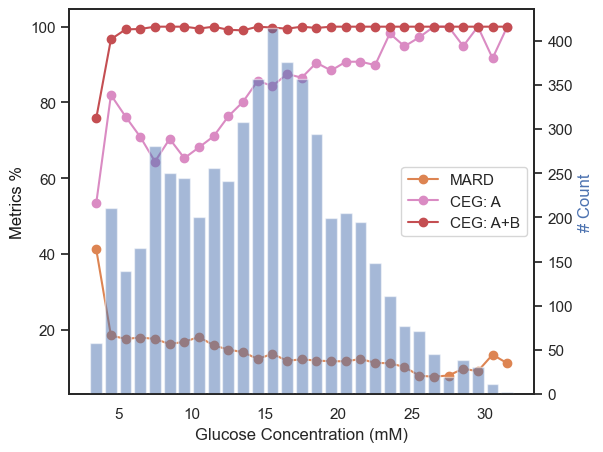

In [11]:
mard_cross, CEG_A_cross, CEG_AB_cross, count_cross = plot_intervals(ref_values_cross, pred_values_cross, 'cross')

In [12]:
data_test = pd.read_excel('Dataset_muSORS.xlsx', sheet_name='Fig. 4b-d, Fig. 5')
data_test = data_test.to_numpy()

In [13]:
subject_test = data_test[2:, 0]
sampling_point_test = data_test[2:, 1]
VPG_test = data_test[2:, 2]
y_true_1_test = num2str_array(data_test[2:, 3])
y_pred_1_test = num2str_array(data_test[2:, 4])
y_true_2_test = num2str_array(data_test[2:, 5])
y_pred_2_test = num2str_array(data_test[2:, 6])
subject_number_test = np.array([int(x[1:]) if not pd.isnull(x) else np.nan for x in subject_test])
subject_type_test = np.array([x[0] if not pd.isnull(x) else np.nan for x in subject_test])

In [14]:
ref_values_test = np.concatenate((y_true_1_test[~np.isnan(y_true_1_test)], y_true_2_test[~np.isnan(y_true_2_test)]))
pred_values_test = np.concatenate((y_pred_1_test[~np.isnan(y_pred_1_test)], y_pred_2_test[~np.isnan(y_pred_2_test)]))

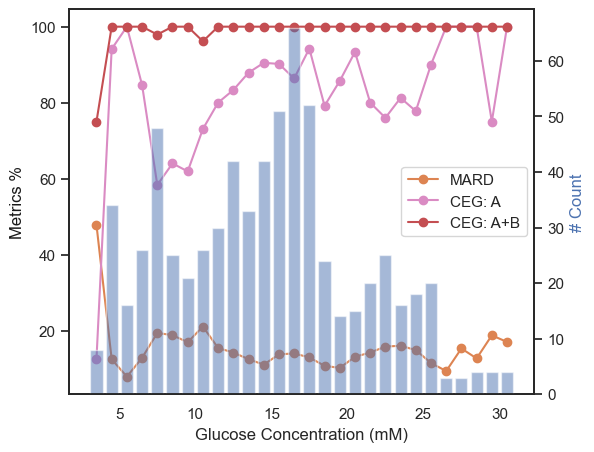

In [15]:
mard_test, CEG_A_test, CEG_AB_test, count_test = plot_intervals(ref_values_test, pred_values_test, 'test')

In [16]:
data_train = pd.read_excel('Dataset_muSORS.xlsx', sheet_name='Extended Data Fig. 9')
data_train = data_train.to_numpy()

In [17]:
subject_train = data_train[2:, 0]
sampling_point_train = data_train[2:, 1]
VPG_train = data_train[2:, 2]
y_true_1_train = num2str_array(data_train[2:, 3])
y_pred_1_train = num2str_array(data_train[2:, 4])
y_true_2_train = num2str_array(data_train[2:, 5])
y_pred_2_train = num2str_array(data_train[2:, 6])
subject_number_train = np.array([int(x[1:]) if not pd.isnull(x) else np.nan for x in subject_train])
subject_type_train = np.array([x[0] if not pd.isnull(x) else np.nan for x in subject_train])

In [18]:
ref_values_train = np.concatenate((y_true_1_train[~np.isnan(y_true_1_train)], y_true_2_train[~np.isnan(y_true_2_train)]))
pred_values_train = np.concatenate((y_pred_1_train[~np.isnan(y_pred_1_train)], y_pred_2_train[~np.isnan(y_pred_2_train)]))

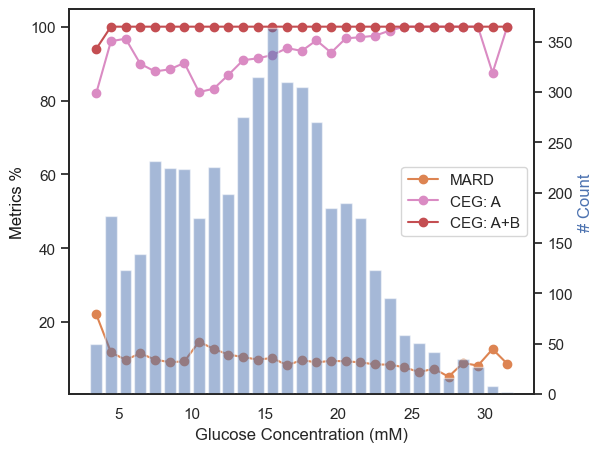

In [19]:
mard_train, CEG_A_train, CEG_AB_train, count_train = plot_intervals(ref_values_train, pred_values_train, 'train')